In [ ]:
# default_exp complete

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
# stellt sicher, dass beim verändern der core library diese wieder neu geladen wird
%load_ext autoreload
%autoreload 2

# Complete and Combine

## Basic Settings

In [ ]:
# imports
from bfh_mt_hs2020_sec_data.core import * 
from pathlib import Path
from typing import List, Tuple, Union, Set

import pandas as pd

import shutil          # provides high level file operations
import time            # used to measure execution time
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [ ]:
all_pivot_selected_folder  = "D:/data/parq_pivot_select"
all_pivoted_folder = "D:/data/parq_pivot_split"
all_processed_folder = "D:/data/parq_processed/"

pivot_group = ["cik","ticker","adsh","period","filed","form","qtrs","fp"]
analyze_fields = ["value_count","null_count","difference"]

## 02_Tools

In [ ]:
def count_null(df: pd.DataFrame):
    columns = list(df.columns)
    value_cols = set(columns) -  set(pivot_group)
    value_cols = value_cols -  set(analyze_fields)
    
    df['value_count'] = df[value_cols].notnull().sum(axis=1)
    df['null_count'] = df[value_cols].isnull().sum(axis=1)
    
    print("lines with missing values: ", df[df.null_count > 0].shape[0])

In [ ]:
def load_data(stmt:str) -> pd.DataFrame:
    df = pd.read_csv(all_processed_folder + stmt + "_not_cleaned.csv")
    df.period = pd.to_datetime(df.period)
    df.filed = pd.to_datetime(df.filed)
    
    return df

In [ ]:
def check_number_of_reports(df: pd.DataFrame):
    """
    check if there is only one entry per report (unique adsh)
    """
    print("is there just one report per ADSH: ", len(df.adsh.unique()) == df.shape[0])

In [ ]:
def missing_value_report(df: pd.DataFrame):
    df_missing = df[df.null_count > 0]
    print(df_missing.shape[0])
    sns.catplot(x='null_count', kind='count', data=df_missing)

## 01_Complete BS

### load data

In [ ]:
bs_df = load_data("bs")
count_null(bs_df)

lines with missing values:  1301


In [ ]:
bs_df.shape

(116519, 18)

In [ ]:
check_number_of_reports(bs_df)

is there just one report per ADSH:  True


### complete missing Equity

In [ ]:
# complete Equity_hj = Assets - Liabilities
do_set_equity = (bs_df.Equity_hj.isnull()  & bs_df.Assets.notnull() & bs_df.Liabilities.notnull())
bs_df.loc[do_set_equity, 'Equity_hj'] = bs_df.loc[do_set_equity, 'Assets'] - bs_df.loc[do_set_equity, 'Liabilities']

In [ ]:
count_null(bs_df)

lines with missing values:  559


### complete missing liabilities

In [ ]:
do_set_liab = (bs_df.Assets.notnull()  & bs_df.Equity_hj.notnull()  & bs_df.Liabilities.isnull() & bs_df.LiabilitiesCurrent.isnull() & bs_df.LiabilitiesNoncurrent.isnull())
bs_df.loc[do_set_liab, 'Liabilities'] = bs_df.loc[do_set_liab, 'Assets'] - bs_df.loc[do_set_liab, 'Equity_hj']
bs_df.loc[do_set_liab, 'LiabilitiesCurrent'] = bs_df.loc[do_set_liab, 'Liabilities']
bs_df.loc[do_set_liab, 'LiabilitiesNoncurrent'] = 0.0

In [ ]:
count_null(bs_df)

lines with missing values:  282


### complete missing assets

In [ ]:
do_set_liab = (bs_df.Liabilities.notnull()  & bs_df.Equity_hj.notnull()  & bs_df.Assets.isnull() & bs_df.AssetsCurrent.isnull() & bs_df.AssetsNoncurrent.isnull())
bs_df.loc[do_set_liab, 'Assets'] = bs_df.loc[do_set_liab, 'Liabilities'] + bs_df.loc[do_set_liab, 'Equity_hj']
bs_df.loc[do_set_liab, 'AssetsCurrent'] = bs_df.loc[do_set_liab, 'Liabilities']
bs_df.loc[do_set_liab, 'AssetsNoncurrent'] = 0.0

In [ ]:
count_null(bs_df)

lines with missing values:  274


### remove companies with incomplete balancesheets

In [ ]:
incomplete_ciks = bs_df[bs_df.null_count > 3].cik.unique()
print(len(incomplete_ciks))

82


In [ ]:
bs_cleaned = bs_df[~bs_df.cik.isin(incomplete_ciks)]

In [ ]:
bs_cleaned.shape

(114481, 18)

### save

In [ ]:
bs_cleaned.drop(columns=analyze_fields).to_csv(all_processed_folder + "bs_clean.csv", index=False)

## 02_Complete CF

### load data

In [ ]:
cf_df = load_data("cf")
count_null(cf_df)

lines with missing values:  1359


In [ ]:
cf_df.shape

(116187, 18)

In [ ]:
check_number_of_reports(cf_df)

is there just one report per ADSH:  True


### complete CashIncreaseDecrease

In [ ]:
# per definition CashIncreaseDecrease = NetCashProvidedByUsedInOperatingActivities + NetCashProvidedByUsedInInvestingActivities + NetCashProvidedByUsedInFinancingActivities
do_set_cshinc = (cf_df.CashIncreaseDecrease_hj.isnull()  & cf_df.NetCashProvidedByUsedInOperatingActivities.notnull()  & 
                 cf_df.NetCashProvidedByUsedInInvestingActivities.notnull() & cf_df.NetCashProvidedByUsedInFinancingActivities.notnull())
cf_df.loc[do_set_cshinc, 'CashIncreaseDecrease_hj'] = cf_df.loc[do_set_cshinc, 'NetCashProvidedByUsedInOperatingActivities'] \
                                                    + cf_df.loc[do_set_cshinc, 'NetCashProvidedByUsedInInvestingActivities'] \
                                                    + cf_df.loc[do_set_cshinc, 'NetCashProvidedByUsedInFinancingActivities'] 

In [ ]:
count_null(cf_df)

lines with missing values:  377


### complete NetCashProvidedByUsedInOperatingActivities

In [ ]:
# per definition CashIncreaseDecrease = NetCashProvidedByUsedInOperatingActivities + NetCashProvidedByUsedInInvestingActivities + NetCashProvidedByUsedInFinancingActivities
# hence NetCashProvidedByUsedInOperatingActivities = CashIncreaseDecrease - (NetCashProvidedByUsedInInvestingActivities + NetCashProvidedByUsedInFinancingActivities)
do_set_netop = (cf_df.CashIncreaseDecrease_hj.notnull()  & cf_df.NetCashProvidedByUsedInOperatingActivities.isnull()  & 
                 cf_df.NetCashProvidedByUsedInInvestingActivities.notnull() & cf_df.NetCashProvidedByUsedInFinancingActivities.notnull())
cf_df.loc[do_set_netop, 'NetCashProvidedByUsedInOperatingActivities'] = cf_df.loc[do_set_netop, 'CashIncreaseDecrease_hj'] \
                                                                      - (cf_df.loc[do_set_netop, 'NetCashProvidedByUsedInInvestingActivities']  + cf_df.loc[do_set_netop, 'NetCashProvidedByUsedInFinancingActivities'] )

In [ ]:
count_null(cf_df)

lines with missing values:  316


### remove companies with incomplete cash flow statment

In [ ]:
incomplete_ciks = cf_df[cf_df.null_count > 1].cik.unique()
print(len(incomplete_ciks))

146


In [ ]:
cf_cleaned = cf_df[~cf_df.cik.isin(incomplete_ciks)]

In [ ]:
cf_cleaned.shape

(112417, 18)

### save

In [ ]:
cf_cleaned.drop(columns=analyze_fields).to_csv(all_processed_folder + "cf_clean.csv", index=False)

## 03_Complete IS

### load data

In [ ]:
is_df = load_data("is")
count_null(is_df)

lines with missing values:  115883


In [ ]:
is_df.shape

(115899, 21)

In [ ]:
check_number_of_reports(is_df)

is there just one report per ADSH:  True


### complete GrossProfit

In [ ]:
# per definition Grossprofit = Revenues - CostOfRevenue
do_set_grossp = (is_df.Revenues_hj.notnull()  & is_df.CostOfRevenue_hj.notnull()  & is_df.GrossProfit.isnull())
is_df.loc[do_set_grossp, 'GrossProfit'] = is_df.loc[do_set_grossp, 'Revenues_hj'] - is_df.loc[do_set_grossp, 'CostOfRevenue_hj']

In [ ]:
# per definition: grossprofit - opexpenses = op-income -> grossprofit = opincome + opexpenses
do_set_grossp1 = (is_df.OperatingExpenses.notnull()  & is_df.OperatingIncomeLoss_hj.notnull()  & is_df.GrossProfit.isnull())
is_df.loc[do_set_grossp1, 'GrossProfit'] = is_df.loc[do_set_grossp1, 'OperatingIncomeLoss_hj'] + is_df.loc[do_set_grossp1, 'OperatingExpenses']

### complete Revenues

In [ ]:
# per definition Grossprofit = Revenues - CostOfRevenue -> Revenues = Grossprofit + CostOfRevenue
do_set_rev = (is_df.Revenues_hj.isnull()  & is_df.CostOfRevenue_hj.notnull()  & is_df.GrossProfit.notnull())
is_df.loc[do_set_rev, 'Revenues_hj'] = is_df.loc[do_set_rev, 'CostOfRevenue_hj'] - is_df.loc[do_set_rev, 'GrossProfit']
set_to_zero_if_null(is_df,'Revenues_hj')

### complete CostOfRevenue

In [ ]:
# per definition Grossprofit = Revenues - CostOfRevenue -> CostOfRevenue = Revenues - Grossprofit
do_set_cstrev = (is_df.Revenues_hj.notnull()  & is_df.CostOfRevenue_hj.isnull()  & is_df.GrossProfit.notnull())
is_df.loc[do_set_cstrev, 'CostOfRevenue_hj'] = is_df.loc[do_set_cstrev, 'Revenues_hj'] - is_df.loc[do_set_cstrev, 'GrossProfit']

### complete OperatingIncomeLoss

In [ ]:
# per definition: opIncomeLoss = grossprofit - opexpenses
do_set_opinc = (is_df.OperatingExpenses.notnull()  & is_df.GrossProfit.notnull()  & is_df.OperatingIncomeLoss_hj.isnull())
is_df.loc[do_set_opinc, 'OperatingIncomeLoss_hj'] = is_df.loc[do_set_opinc, 'GrossProfit'] - is_df.loc[do_set_opinc, 'OperatingExpenses']

### estimate OperatingIncomeLoss_hj based on GrossProfit and NetIncomeLoss

In [ ]:
todo

### estimate OperatingIncomeLoss_hj based on Revenues and NetIncomeLoss

In [ ]:
todo

### estimate GrossProfit based on Revenue and OperatingIncomeLoss

In [ ]:
# if Grossprofit is not set, we can try to estimate it based on the average

# based on existing GrossProfit Values, we calculate the average grossprofit between Revenue and OperatingIncome (in percent)
calc_mean_gp_selection = ((is_df.Revenues_hj > 0.0)  & (is_df.GrossProfit.notnull()  & is_df.OperatingIncomeLoss_hj.notnull()))
selected_cols = is_df[calc_mean_gp_selection][['Revenues_hj','GrossProfit','OperatingIncomeLoss_hj']].copy()

avg_gross = ((selected_cols.Revenues_hj-selected_cols.GrossProfit)/(selected_cols.Revenues_hj-selected_cols.OperatingIncomeLoss_hj)).mean()

# if we have revenue and operatingincome, we try estimate grossprofit based on the average position
do_updated_grossprofit = (is_df.Revenues_hj.notnull() & is_df.OperatingIncomeLoss_hj.notnull() & is_df.GrossProfit.isnull())

is_df.loc[do_updated_grossprofit,'GrossProfit'] = is_df.loc[do_updated_grossprofit,'Revenues_hj'] \
                                    - avg_gross * (is_df.loc[do_updated_grossprofit,'Revenues_hj'] - is_df.loc[do_updated_grossprofit,'OperatingIncomeLoss_hj'])


In [ ]:
is_df[do_updated_grossprofit][['cik','ticker','adsh','Revenues_hj','GrossProfit','OperatingIncomeLoss_hj']]

,cik,ticker,adsh,Revenues_hj,GrossProfit,OperatingIncomeLoss_hj
1,1465112,DTV,0001047469-14-001182,3.175400e+10,1.804006e+10,5.150000e+09
3,726854,CHCO,0000726854-19-000112,6.667900e+07,4.703133e+07,2.856400e+07
10,1527590,ZFC,0001558370-18-006746,6.157600e+07,3.836530e+07,1.654900e+07
11,1098972,AGEN,0001564590-16-018449,5.958876e+06,-1.153046e+07,-2.796912e+07
12,1275229,GMO,0001558370-18-002006,0.000000e+00,-3.674885e+06,-7.129000e+06
...,...,...,...,...,...,...
115885,1481506,PNG,0001104659-12-075408,6.612700e+07,4.228071e+07,1.986700e+07
115888,1297996,DLR,0001297996-17-000057,5.505690e+08,3.375267e+08,1.372830e+08
115895,1008586,STRM,0001558370-19-008592,4.793000e+06,2.099081e+06,-4.330000e+05
115896,44689,GYRO,0001437749-14-014713,6.349990e+05,-3.549586e+05,-1.285444e+06


In [ ]:
(is_df.Revenues_hj.isnull() | is_df.GrossProfit.isnull() | is_df.OperatingIncomeLoss_hj.isnull() | is_df.NetIncomeLoss_hj.isnull()).sum()

4478

OperatingIncome
- können wir nur von oben nauch unten nachrechnen, da keine differenz zu netincome vorhanden ist
- man könnte opertating income schätzen, falls REvenue und NetIncome vorhanden ist -> gleich wie auch GrossProfit geschätzt werden kann

Grossprofit if null
- falls CostAndExpenses + OperationgIncome ~= Revenue
  dann könnte man grossprofit schätzen -> Operating income + 0.5* CostAndExpenses
  
  

## XX_Trials

In [ ]:
is_df[((is_df.Revenues_hj.notnull() & is_df.GrossProfit.notnull() & is_df.OperatingIncomeLoss_hj.isnull() & is_df.NetIncomeLoss_hj.notnull() ))] \
  [['cik','adsh','Revenues_hj','GrossProfit','OperatingIncomeLoss_hj', 'NetIncomeLoss_hj', 'OperatingExpenses','CostsAndExpenses']] #721

,cik,adsh,Revenues_hj,GrossProfit,OperatingIncomeLoss_hj,NetIncomeLoss_hj,OperatingExpenses,CostsAndExpenses
386,918646,0001564590-15-008677,3.289880e+08,4.429400e+07,NaN,2.981900e+07,NaN,NaN
638,701374,0001047469-13-001833,1.070332e+09,9.901630e+08,NaN,3.540090e+08,NaN,NaN
673,1298675,0001298675-19-000015,1.528450e+08,1.014200e+08,NaN,3.549800e+07,NaN,99014000.0
713,799850,0001171843-16-012077,1.458400e+08,7.032700e+07,NaN,7.099000e+06,NaN,134502000.0
1100,914025,0000914025-19-000045,4.477670e+08,2.126460e+08,NaN,-4.487100e+07,NaN,NaN
...,...,...,...,...,...,...,...,...
113606,29915,0000029915-15-000055,1.203600e+10,2.687000e+09,NaN,1.375000e+09,NaN,NaN
113696,895051,0001144204-17-017953,0.000000e+00,0.000000e+00,NaN,-9.453488e+06,NaN,9420610.0
115371,918646,0001564590-18-025641,3.814990e+08,9.793100e+07,NaN,7.260300e+07,NaN,NaN
115748,1466085,0001564590-20-005043,2.032230e+08,1.954970e+08,NaN,4.589600e+07,NaN,152854000.0


In [ ]:
is_df[((is_df.Revenues_hj.isnull() | is_df.GrossProfit.isnull() | is_df.OperatingIncomeLoss_hj.isnull() | is_df.NetIncomeLoss_hj.isnull() ))] \
  [['cik','adsh','Revenues_hj','GrossProfit','OperatingIncomeLoss_hj', 'NetIncomeLoss_hj', 'OperatingExpenses','CostsAndExpenses']] #721

,cik,adsh,Revenues_hj,GrossProfit,OperatingIncomeLoss_hj,NetIncomeLoss_hj,OperatingExpenses,CostsAndExpenses
55,1399541,0001193125-12-462451,1.797200e+06,NaN,NaN,-631900.0,NaN,2429200.0
58,1571283,0001571283-18-000030,4.853600e+07,NaN,NaN,14766000.0,37574000.0,NaN
75,1507986,0001144204-12-029739,0.000000e+00,NaN,NaN,-286262.0,NaN,290266.0
84,1046050,0000939057-18-000051,1.317200e+07,NaN,NaN,3614000.0,278000.0,NaN
85,1405528,0001104659-20-058630,-2.501457e+07,NaN,NaN,-25119958.0,NaN,NaN
...,...,...,...,...,...,...,...,...
115889,217346,0001104659-19-055774,3.259000e+09,512000000.0,NaN,220000000.0,NaN,NaN
115892,65172,0001104659-14-044501,5.034350e+05,NaN,NaN,137218.0,NaN,NaN
115893,825313,0000825313-18-000058,0.000000e+00,NaN,NaN,65900000.0,NaN,NaN
115894,60086,0001193125-12-441141,3.715000e+09,NaN,NaN,177000000.0,NaN,NaN


In [ ]:
is_df[((is_df.CostsAndExpenses.notnull() & is_df.GrossProfit.isnull() & is_df.OperatingIncomeLoss_hj.isnull()))][['cik','adsh','CostsAndExpenses', 'OperatingExpenses','GrossProfit','OperatingIncomeLoss_hj']] #721
#is_df[((is_df.OperatingExpenses.notnull() & is_df.GrossProfit.isnull() & is_df.OperatingIncomeLoss_hj.notnull()))][['cik','adsh','OperatingExpenses','GrossProfit','OperatingIncomeLoss_hj']] #11618

,cik,adsh,CostsAndExpenses,OperatingExpenses,GrossProfit,OperatingIncomeLoss_hj
55,1399541,0001193125-12-462451,2.429200e+06,NaN,NaN,NaN
124,1399542,0001193125-13-135825,7.784700e+06,NaN,NaN,NaN
150,820027,0000820027-14-000020,9.229000e+09,NaN,NaN,NaN
156,1283810,0001193125-12-462787,4.129000e+05,NaN,NaN,NaN
184,1393311,0001393311-19-000041,3.710000e+08,NaN,NaN,NaN
...,...,...,...,...,...,...
115241,1357361,0001193125-13-135714,6.750500e+06,NaN,NaN,NaN
115365,1399542,0001564590-15-007375,7.840000e+05,NaN,NaN,NaN
115606,1037540,0001656423-20-000007,1.914925e+09,NaN,NaN,NaN
115685,1479094,0001104659-12-035291,1.543100e+07,NaN,NaN,NaN


In [ ]:
is_df.isnull().sum(axis=0)

cik                           0
ticker                        0
adsh                          0
period                        0
filed                         0
form                          0
qtrs                          0
fp                            1
Revenues_hj                   0
CostOfRevenue_hj          36655
GrossProfit                3590
OperatingExpenses         73773
OperatingIncomeLoss_hj     3903
CostsAndExpenses          87531
NetIncomeLoss_hj            621
NetIncomeLoss             15026
ProfitLoss                76441
SharesOutstanding_hj      40947
EarningsPerShare_hj        7099
value_count                   0
null_count                    0
dtype: int64

In [ ]:
is_df.adsh.value_counts()

0000049826-16-000259    1
0001193125-13-432993    1
0000023666-13-000019    1
0001437749-17-013867    1
0001104659-15-059052    1
                       ..
0001564590-16-014500    1
0000808326-17-000011    1
0001144204-14-064668    1
0001104659-15-075802    1
0001628280-19-012903    1
Name: adsh, Length: 115899, dtype: int64

316


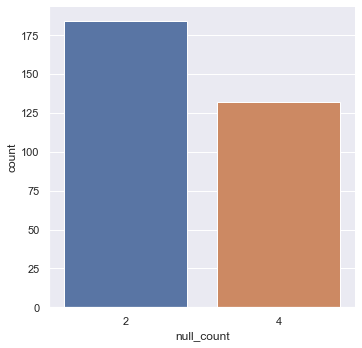

In [ ]:
missing_value_report(cf_df)

In [ ]:
len(bs_df.adsh.unique()) == bs_df.shape[0]

True

In [ ]:
cf_df.dtypes

cik                                                    int64
ticker                                                object
adsh                                                  object
period                                        datetime64[ns]
filed                                         datetime64[ns]
form                                                  object
qtrs                                                   int64
fp                                                    object
CashIncreaseDecrease_hj                              float64
NetIncomeLoss                                        float64
ProfitLoss                                           float64
NetCashProvidedByUsedInOperatingActivities           float64
NetCashProvidedByUsedInInvestingActivities           float64
NetCashProvidedByUsedInFinancingActivities           float64
PaymentsOfDividendsTotal_hj                          float64
PaymentsForRepurchaseOfStockTotal_hj                 float64
value_count             

In [ ]:
sum(bs_df.qtrs>0)

1349


IS
Was kann man alles berechnen, wenn vorhanden
GrossProfit = Revenues - costofsales
OperatingIncome = (GrossProfit) - CostsAndExpenses
OperatingIncome = Revenues - CostsAndExpenses

In [ ]:
df = cf_df[(cf_df.null_count == 4)]
print(df.shape[0])
print(df.ticker.value_counts())

132
REG     20
LM      19
SKT      5
WLS      4
BMR      3
        ..
PAH      1
WGL      1
KODK     1
WM       1
AEE      1
Name: ticker, Length: 66, dtype: int64


In [ ]:
df[df.ticker=='REG']

,cik,ticker,adsh,period,filed,form,qtrs,fp,CashIncreaseDecrease_hj,NetIncomeLoss,ProfitLoss,NetCashProvidedByUsedInOperatingActivities,NetCashProvidedByUsedInInvestingActivities,NetCashProvidedByUsedInFinancingActivities,PaymentsOfDividendsTotal_hj,PaymentsForRepurchaseOfStockTotal_hj,value_count,null_count
4076,910606,REG,0000910606-13-000009,2012-12-31,2013-03-01,10-K,4,FY,NaN,NaN,NaN,NaN,0.0,0.0,0.0,323125000.0,4,4
9886,910606,REG,0000910606-14-000008,2014-03-31,2014-05-08,10-Q,1,Q1,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,4,4
30704,910606,REG,0000910606-14-000033,2014-09-30,2014-11-04,10-Q,3,Q3,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,4,4
42848,910606,REG,0000910606-16-000073,2016-06-30,2016-08-05,10-Q,2,Q2,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,4,4
44157,910606,REG,0000910606-13-000030,2013-09-30,2013-11-01,10-Q,3,Q3,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,4,4
45278,910606,REG,0000910606-13-000026,2013-06-30,2013-08-02,10-Q,2,Q2,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,4,4
49340,910606,REG,0000910606-18-000030,2018-06-30,2018-08-03,10-Q,2,Q2,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,4,4
50505,910606,REG,0000910606-15-000006,2014-12-31,2015-02-20,10-K,4,FY,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,4,4
52818,910606,REG,0000910606-14-000029,2014-06-30,2014-08-08,10-Q,2,Q2,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,4,4
55494,910606,REG,0000910606-16-000047,2015-12-31,2016-02-18,10-K,4,FY,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,4,4


In [ ]:
cf_df_missing = cf_df[cdf_df.null_count > 0]
print(bs_df_missing.shape[0])
sns.catplot(x='null_count', kind='count', data=cf_df_missing)

NameError: name 'cdf_df' is not defined

bs_df[bs_df.fp.isna()]

BS
Checks:
- Assets = Liabilities + Equity

In [ ]:
CF
Cash Differenz kann auch aufgrund des vergangenen geschäftsbericht ermittlet werden -> Position Cash im BS